# RF Signal Integrity to Power Integrity:  Part 10 Zout from Time-Domain

This folder contains the 1st simulation of the  
["part10"](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) of a series blog/article  
[RF Signal Integrity to Power Integrity](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) on  
[Microwave Journal](https://www.microwavejournal.com/).


# Install PyQSPICE First!

In your cmd.exe window.
```
> pip install PyQSPICE
```

## After Python Script

This folder contains resulting files after running the Python Script.
The [**"Sim2"**](https://github.com/Qorvo/QSPICE_on_MWJ/tree/main/Article10/Sim2) folder next to this-folder is "before running script".


## Overview Part 10, Sim #2

In Part-10, throughout [QSPICE](qspice.com) simulations, we confirm that the following equiation is valid where we can obtain an output impedance curve of frequency-domain based on a step-response transient / time-domain simulation.

$$
ℒ\left( \frac{d}{dt}\left( V_{OUT,Step-Response}(t) \right) \right) = - Z_{OUT}(s)
$$

In this Sim-2, we use a simple VRM output impedance model circuit.

## 1. Schematic and Netlists

We use below schmatic and generates 2 netlists for transient (time-domain) and AC (frequency-domain).

![](ZoModel.sch.png)

In [1]:
from PyQSPICE import clsQSPICE as pqs

import re
import subprocess
import math
import cmath

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.transforms import ScaledTranslation as stran

import numpy as np
from numpy import sin, cos, pi, linspace

fname = "ZoModel"
run = pqs(fname)
run.qsch2cir()
run.cir4label('ac')
run.cir4label('tran')


## 2. AC Simulation: Reference Data

First, we run an AC simulation for our reference data.

From the Q(Tg) plot, we can see that this VRM output impedance model has Q = 1.5.

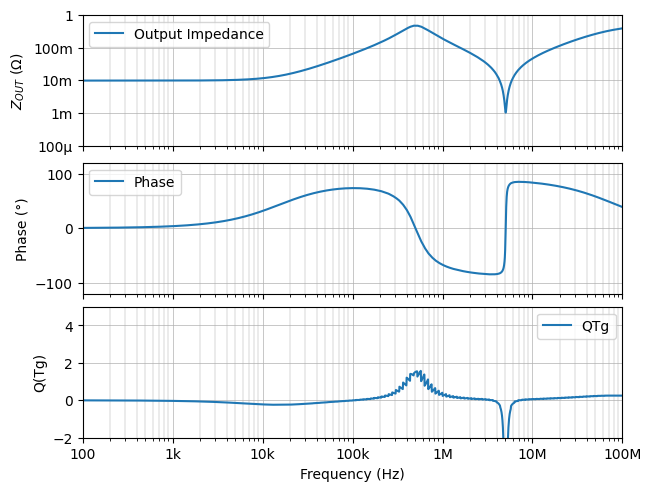

In [2]:
Ndata = 1024*4
run.selectSimLabel('ac', Nline = Ndata)

run.cir2qraw()

v = "V(OUT)"
i = "I(Iac)"

dfAC = run.LoadQRAW([v])

dfAC = run.GainPhase(dfAC, v, "abs(Zoac)", "arg(Zoac)")
run.comp2real(dfAC, ["Step", "abs(Zoac)", "arg(Zoac)", run.sim['Xlbl']])
#print(dfAC)

dfQ = pd.DataFrame()
dfQ = run.QTg(dfAC.loc[:,["Freq","arg(Zoac)"]], "fQTg", "QTg", 180/pi)
#print(dfQ)

plt.close('all')

fig, (axT, axM, axB) = plt.subplots(3, 1, sharex=True, constrained_layout=True)

dfAC.plot(ax=axT, x="Freq", y="abs(Zoac)", label="Output Impedance")
dfAC.plot(ax=axM, x="Freq", y="arg(Zoac)", label="Phase")
dfQ.plot(ax=axB, x="fQTg", y="QTg")
run.PrepFreqImpePlot(axT, "Frequency (Hz)", r"$Z_{OUT}$ ($\Omega$)", "auto", [-80,0], "")
run.PrepFreqGainPlot(axM, "Frequency (Hz)", r"Phase (°)", [100,1e8], [-120,120], "")
run.PrepFreqGainPlot(axB, "Frequency (Hz)", r"Q(Tg)", [100,1e8], [-2,5], "")

plt.savefig("ZoModel.ac.png", format='png', bbox_inches='tight')

plt.show()


## 3. Transient Simulation: Step-Load

Now, we run a transient simulation with the step current load.

This simulation generates total 10ms of data points, so we can have frequency information down to 100Hz.

As we have Q = 1.5, we can see not heavy but a couple of ringing peaks.

### NOTEs
Many data points to simulate and process, for high precision results.  
Please check time-stamps for a rough idea how long does it take (depending on your PC speed)...  
At author's PC, 2min simulation and 2min data-loading.  
  
It generates **> 2GB data file**!


Simulation started at 2024-04-11 10:41:28.120506
Simulation finished at 2024-04-11 10:43:32.928193
Data Loading started at 2024-04-11 10:43:32.929193
Data Loading finished at 2024-04-11 10:45:09.541133
Data Plotting...


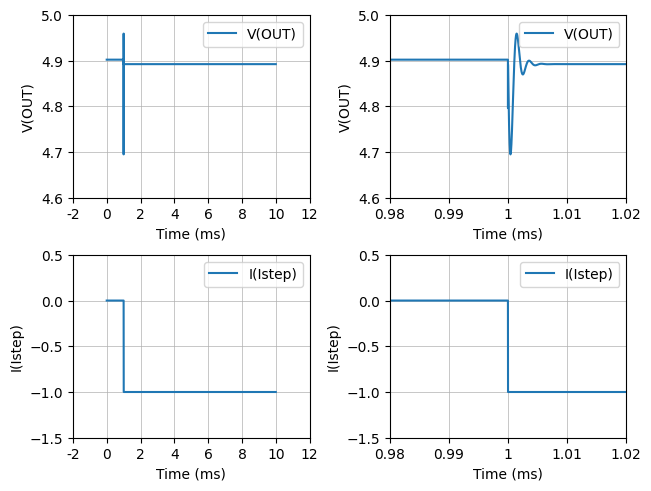

In [3]:
Ndata = 1024*1024
run.selectSimLabel('tran', Nline = Ndata)

import datetime

print("Simulation started at " + str(datetime.datetime.now()))

run.cir2qraw()
#run.copy2qraw()  #use this line to re-use existing QRAW file

print("Simulation finished at " + str(datetime.datetime.now()))
print("Data Loading started at " + str(datetime.datetime.now()))

v = "V(OUT)"
i = "I(G2)"

dfTRAN = run.LoadQRAW([v,i])
#print(dfTRAN)

print("Data Loading finished at " + str(datetime.datetime.now()))
print("Data Plotting...")

plt.close('all')

fig, ax = plt.subplots(2, 2, constrained_layout=True)

for n in [0, 1]:
    dfTRAN.plot(ax=ax[0,n], x="Time", y=v, label="V(OUT)")
    dfTRAN.plot(ax=ax[1,n], x="Time", y=i, label="I(Istep)")

run.PrepTimePlot(ax[0,0], "Time", r"V(OUT)", "auto", [4.6,5.0], "")
run.PrepTimePlot(ax[1,0], "Time", r"I(Istep)", "auto", [-1.5,0.5], "")
run.PrepTimePlot(ax[0,1], "Time", r"V(OUT)",  [0.98e-3,1.02e-3], [4.6,5.0], "")
run.PrepTimePlot(ax[1,1], "Time", r"I(Istep)", [0.98e-3,1.02e-3], [-1.5,0.5], "")

plt.savefig("ZoModel.tran.png", format='png', bbox_inches='tight')

plt.show()


## 4. Data Processing:  L( d/dt(unit-response) )

Finally, we run FFT and Laplace transform, so to obtain / reconstruct our output impedance curve.

We can see good matching between our output impedance reconstruction method from time-domain and straight AC simulation.

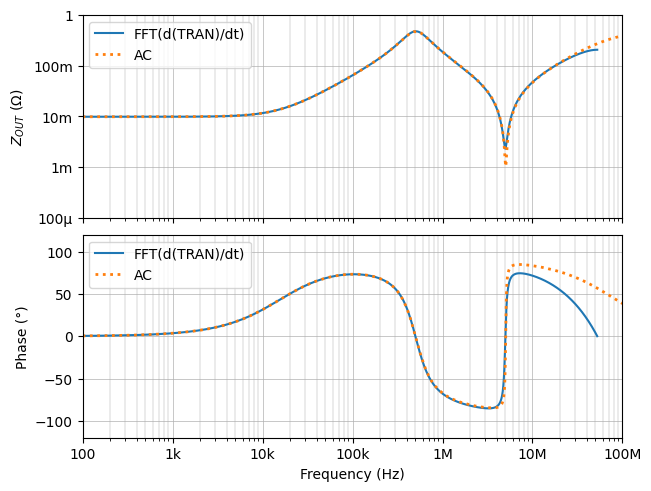

In [4]:
dfVo = dfTRAN[v].diff().iloc[1:]
dfIo = dfTRAN[i].diff().iloc[1:]
step = dfTRAN.iloc[1,0]

ftVo = (np.fft.fft(dfVo))[0:int(Ndata/2)]
ftIo = (np.fft.fft(dfIo))[0:int(Ndata/2)]
freq = (np.fft.fftfreq(Ndata,d=step))[0:int(Ndata/2)]

absZ = 20*np.log10(np.abs(ftVo / ftIo))
angZ = np.angle(ftVo / ftIo) / np.pi * 180

plt.close('all')

fig, (axT, axB) = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axT.plot(freq, absZ, label="FFT(d(TRAN)/dt)")
axB.plot(freq, angZ, label="FFT(d(TRAN)/dt)")
axT.legend()
axB.legend()

dfAC.plot(ax=axT, x="Freq", y="abs(Zoac)", label="AC", linestyle="dotted", linewidth=2)
dfAC.plot(ax=axB, x="Freq", y="arg(Zoac)", label="AC", linestyle="dotted", linewidth=2)

run.PrepFreqImpePlot(axT, "Frequency (Hz)", r"$Z_{OUT}$ ($\Omega$)", "auto", [-80,0], "")
run.PrepFreqGainPlot(axB, "Frequency (Hz)", r"Phase (°)", [100,1e8], [-120,120], "")

plt.savefig("ZoModel.Lddt.png", format='png', bbox_inches='tight')

plt.show()


## 5. Cleaning

Removing 1GB data file.

In [5]:
run.clean(['tran.qraw'])